In [28]:
from madgwickahrs import * 
from quaternion import Quaternion
from conversion import * 
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from scipy.stats import norm
from numpy import linalg as LA
from numpy.linalg import inv
import time
from IPython.display import Image as ImageDisp
from sympy import Symbol, symbols, Matrix, sin, cos, latex#, Plot
from sympy.interactive import printing
from a3muse import IntegrationRK4, QuatToRotMat, quatNormalized, AccMagOrientation, QuatToEuler, RotMatToQuat, EulerToRotMat
from quaternionClass import QuaternionClass
printing.init_printing()
%pylab inline --no-import-all


Populating the interactive namespace from numpy and matplotlib


In [29]:
short_len = 6000
dt = 0.025

In [30]:
trajectory_file = open("/Users/eunsunlee/Documents/NESL/UnderwaterSensorTag/IMU_GPS_Fusion/Trajectory_Simulation/simulated_measurement_from_imusim/trajectory_from_imusim.txt",'r')

time = []
px = []
py = []
pz = []
vx = []
vy = []
vz = []
Ax = []
Ay = []
Az = []

len_count = 0 
for i in trajectory_file:
    if len_count > short_len:
        break
    sp = i.split()
    time.append(float(sp[0]))
    px.append(float(sp[1]))
    py.append(float(sp[2]))
    pz.append(float(sp[3]))
    vx.append(float(sp[4]))
    vy.append(float(sp[5]))
    vz.append(float(sp[6]))
    Ax.append(float(sp[7]))
    Ay.append(float(sp[8]))
    Az.append(float(sp[9]))
    len_count += 1
    
trajectory_file.close()
print(len(time))

6001


In [31]:
imu_values_file = open("/Users/eunsunlee/Documents/NESL/UnderwaterSensorTag/IMU_GPS_Fusion/Trajectory_Simulation/simulated_measurement_from_imusim/imu_values_from_imusim.txt",'r')

ax = []
ay = []
az = []
gx = []
gy = []
gz = []
magx = []
magy = []
magz = []

len_count = 0
for i in imu_values_file: 
    if len_count >= short_len:
        pass
    else:
        sp = i.split()
        ax.append(float(sp[1]))
        ay.append(float(sp[2]))
        az.append(float(sp[3]))
        gx.append(float(sp[4]))
        gy.append(float(sp[5]))
        gz.append(float(sp[6]))
        magx.append(float(sp[7]))
        magy.append(float(sp[8]))
        magz.append(float(sp[9]))
    len_count += 1
  

In [32]:
nax = []
nay = []
naz = []
ngx = []
ngy = []
ngz = []
nmagx = []
nmagy = []
nmagz = []

# white gaussian noise with zero mean and variance = 0.0004
wV_Accel = .0004 # Accelerometer white noise variance 
wm_Accel = 0 # Accelerometer white noise mean

# bias with a priori statistics b_a ~ N(0,0.01)
bu_Accel = 0 # Mean of bias term
bV_Accel = 0.01 # Variance of bias (m/s^2)^2


a_wh  = np.random.normal(wm_Accel,np.sqrt(wV_Accel),len(ax))
a_b = np.random.normal(bu_Accel,np.sqrt(bV_Accel),len(ax))
nax = ax + a_wh + a_b
rax = ax
ax = nax

a_wh  = np.random.normal(wm_Accel,np.sqrt(wV_Accel),len(ay))
a_b = np.random.normal(bu_Accel,np.sqrt(bV_Accel),len(ay))
nay = ay + a_wh + a_b
ray = ay
ay = nay

a_wh  = np.random.normal(wm_Accel,np.sqrt(wV_Accel),len(ay))
a_b = np.random.normal(bu_Accel,np.sqrt(bV_Accel),len(ay))
naz = az + a_wh + a_b
raz = az
az = naz

g_wh  = np.random.normal(wm_Accel,np.sqrt(wV_Accel),len(gx))
g_b = np.random.normal(bu_Accel,np.sqrt(bV_Accel),len(gx))
ngx = gx + g_wh + g_b
rgx = gx
gx = ngx

g_wh  = np.random.normal(wm_Accel,np.sqrt(wV_Accel),len(gx))
g_b = np.random.normal(bu_Accel,np.sqrt(bV_Accel),len(gx))
ngy = gy + g_wh + g_b
rgy = gy
gy = ngy

g_wh  = np.random.normal(wm_Accel,np.sqrt(wV_Accel),len(ax))
g_b = np.random.normal(bu_Accel,np.sqrt(bV_Accel),len(ax))
ngz = gz + g_wh + g_b
rgz = gz
gz = ngz




In [33]:
dx = np.diff(px)
dy = np.diff(py)
dz = np.diff(pz)
mx = np.cumsum(dx)
my = np.cumsum(dy)
mz = np.cumsum(dz)

rmx = mx
rmy = my 
rmz = mz 

nmx = []
nmy = []
nmz = []
nvx = []
nvy = []
nvz = []

wmp_GPS = 0 # meters, mean of the white noise measurement of position
wmv_GPS = 0 # meters / second, mean of the white noise measurement of velocity
wVp_GPS = 1 #0.001 #5 meter^2, variance of the white noise measurement of position
wVv_GPS = .04**2 # (4cm/s)**2 = .04**2 (m/s)^2, varaince of the white noise measurement of velocity


mx = np.random.normal(wmp_GPS,np.sqrt(wVp_GPS),len(mx)) + np.array(mx)
my = np.random.normal(wmp_GPS,np.sqrt(wVp_GPS),len(my)) + np.array(my)
mz = np.random.normal(wmp_GPS,np.sqrt(wVp_GPS),len(mz)) + np.array(mz)


No handles with labels found to put in legend.


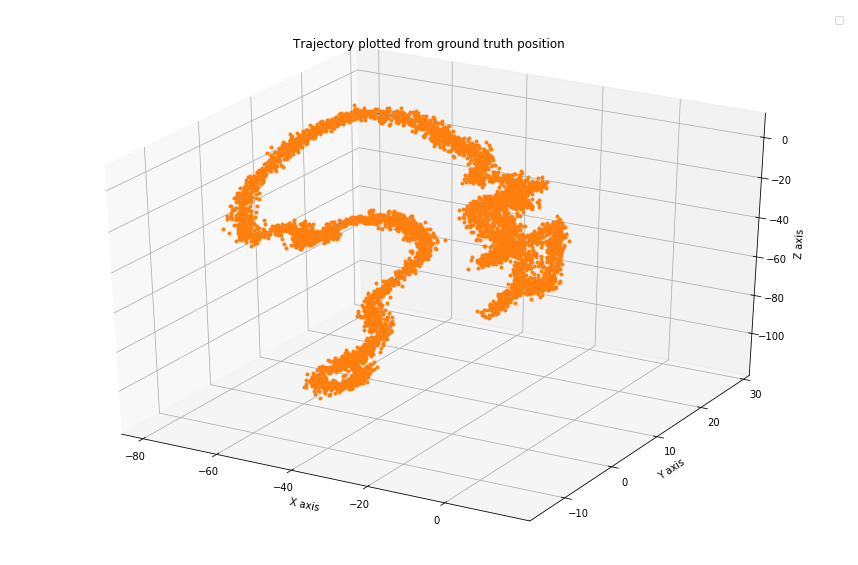

In [34]:

fig = plt.figure(figsize=(15,10))
axplot = fig.gca(projection='3d')
axplot.set_title("Trajectory plotted from ground truth position")
# axplot.plot(rpx, rpy, rpz, label='ground truth position')
axplot.plot(rmx, rmy, rmz)
# axplot.plot(px, py, pz,'.', label='GPS points')
axplot.plot(mx, my, mz,'.')

axplot.legend()
axplot.set_xlabel('X axis')
axplot.set_ylabel('Y axis')
axplot.set_zlabel('Z axis')
plt.show()


In [35]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)
def find_R(V1, V2):
    v1_u = unit_vector(V1)
    v2_u = unit_vector(V2)
    V = np.cross(v1_u, v2_u)
    s = LA.norm(np.cross(v1_u, v2_u))
    c = np.dot(v1_u, v2_u)

    I = np.mat([[1,0,0],[0,1,0],[0,0,1]])
    v1 = V[0]
    v2 = V[1]
    v3 = V[2]
    Vx = np.mat([[0,-v3,v2],[v3,0,-v1],[-v2,v1,0]])
    R = I + Vx + (Vx**2)*((1-c)/s**2)
    return R

In [36]:
GPSFix = []
fix = 0
for i in range(len(ax)):
    if fix == 0:
        GPSFix.append(True)
        fix = fix + 200
    else: 
        fix = fix -1
        GPSFix.append(False)
# print(GPSFix)

In [37]:
YAW = []
PITCH = []
ROLL = []

# Necessary initialization
quat = QuaternionClass(1,0,0,0)
omega0 = [gx[0], gy[0], gz[0]]


# TODO: initial quat given for testing
Azg = np.array(Az) - 9.8
Rot = find_R([ax[0], ay[0], az[0]], [Ax[0], Ay[0], Azg[0]])
Rotmat = Rot
quatfromaA = quatNormalized(RotMatToQuat(np.array(Rotmat)))
quat = QuaternionClass(quatfromaA[0],quatfromaA[1],quatfromaA[2],quatfromaA[3])
yaw0,pitch0,roll0 = QuatToEuler(quat)


Rotmat = []
Rotmat.append(Rot)

for i in range(len(ax)):
    omega1 = [gx[i], gy[i], gz[i]] 
    quatG = IntegrationRK4(omega0, omega1, quat, dt)
    #Calculate next quaternion
    quat = quatG
    omega0 = omega1
    #Calculate next euler 
    yawIMU,pitchIMU,rollIMU = QuatToEuler(quatG)
    
    YAW.append(yawIMU)
    PITCH.append(pitchIMU)
    ROLL.append(rollIMU)
    
    Rotmat.append(QuatToRotMat(quatG))
#     ya = ya + gz[i]*dt
#     pi = pi + gy[i]*dt
#     ro = ro + gx[i]*dt 
#     TestYaw.append(ya)
#     TestPitch.append(pi)
#     TestRoll.append(ro)
    
# print("yaw")
# print(yaw0)
# print(YAW[0])
    
# print("what")
# plt.plot(TestYaw)
# plt.plot(YAW)
# plt.show()
# print("what?")
# print("what")
# plt.plot(TestPitch)
# plt.plot(PITCH)
# plt.show()
# print("what?")
# print("what")
# plt.plot(TestRoll)
# plt.show()
# plt.plot(ROLL)
# plt.show()
# print("what?")


mx = np.array(mx)
my = np.array(my)
mz = np.array(mz)
hmx = []
hmy = []
hmz = []
hmx.append(0)
hmy.append(0)
hmz.append(0)
for i in range(len(mx)):
    hmx.append(mx[i])
    hmy.append(my[i])
    hmz.append(mz[i])

vx = np.array(vx)
vy = np.array(vy)
vz = np.array(vz)
hYAW = []
hPITCH = []
hROLL = []
hYAW.append(0)
hPITCH.append(0)
hROLL.append(0)
for i in range(len(YAW)):
    hYAW.append(YAW[i])
    hPITCH.append(PITCH[i])
    hROLL.append(ROLL[i])
# YAW = np.array(YAW)
# PITCH = np.array(PITCH)
# ROLL = np.array(ROLL)


print(len(hmx))
print(len(vx))
print(len(hYAW))

measurements = np.vstack((hmx, hmy, hmz,
                          vx, \
                          vy, \
                          vz, \
                          hYAW, \
                          hPITCH, \
                          hROLL))
  

6001
6001
6001


In [38]:
numstates = 9
x = np.matrix([[mx[0], my[0], mz[0], vx[0]/1.0, vy[0]/1.0, yaw0, pitch0, roll0]]).T
P = np.eye(numstates)
I = np.eye(numstates)


jerkmax = 300.0    # m/s3
pitchrateaccmax=  200.0 *np.pi/180.0 # rad/s2
rollrateaccmax =  200.0 *np.pi/180.0 # rad/s2
yawrateaccmax  =  80.0  *np.pi/180.0 # rad/s2

# #make it smaller when you trust IMU more 
# Q = np.diagflat([[(dt * jerkmax)/1000],            # acceleration
#                  [(dt * jerkmax)/1000],            # acceleration
#                  [(dt * jerkmax)/1000],            # acceleration
#             [(dt * yawrateaccmax)/100],           # yawrate
#             [(dt * pitchrateaccmax)/100],         # pitchrate
#             [(dt * rollrateaccmax)/100]])         # rollrate


#make it smaller when you trust IMU more 
Q = np.diagflat([[(dt * jerkmax)/1],            # acceleration
                 [(dt * jerkmax)/1],            # acceleration
                 [(dt * jerkmax)/1],            # acceleration
            [(dt * yawrateaccmax)/1],           # yawrate
            [(dt * pitchrateaccmax)/1],         # pitchrate
            [(dt * rollrateaccmax)/1]])         # rollrate


# Make it smaller when you trust GPS more
R = np.diagflat([[(2)**2],      # x
            [(2)**2],           # y
            [(2)**2],           # z
            [(0.001)**2],  # vx
            [(0.001)**2],
            [(0.001)**2],
            [(0.005)**2],  # heading 
            [(0.005)**2],  # pitch
            [(0.005)**2]]) # roll
# print(P.shape)
# print(JA.shape)
# print(JA.T.shape)
# print(R.shape)
# print(JH.shape)

In [39]:
length = 6000

In [40]:
 
TestYaw = []
TestPitch = []
TestRoll = [] 

noKX = []
noKY = []
noKZ = []
p_x = 0
p_y = 0
p_z = 0
noKX.append(p_x)
noKY.append(p_y)
noKZ.append(p_z)

VX = []
VY = []
VZ = []
# TODO: initial vx0 for testing
v_x = vx[0]
v_y = vy[0]
v_z = vz[0]
VX.append(v_x)
VY.append(v_y)
VZ.append(v_z)

AXS = []
AYS = []
AZS = []
AZGS = []

ya = yaw0
pi = pitch0
ro = roll0

Test = []
Test2 = []

#state matrix 
x = np.mat([0, 0, 0, vx[0], vy[0], vz[0], yaw0, pitch0, roll0]).T

for i in range(length):#len(ax)):
    
######### Prediction STEP starts ####################################################
    x[0] = x[0] + x[3]*dt
    x[1] = x[1] + x[4]*dt
    x[2] = x[2] + x[5]*dt
    
    # x[6]- yaw, x[7] - pitch, x[8]- roll 
    sa = sin(x[6]) # sin (yaw + yawrate)
    ca = cos(x[6]) # cos (yaw + yawrate)
    sb = sin(x[8]) # sin (roll + rollrate)
    cb = cos(x[8]) # cos (roll + rollrate
    sh = sin(x[7]) # sin (pitch + pitchrate)
    ch = cos(x[7]) # cos (pitch + pitchrate)
    
    m00 = ch*ca
    m01 = -ch*sa*cb + sh*sb
    m02 = ch*sa*sb + sh*cb
    m10 = sa
    m11 = ca*cb
    m12 = -ca*sb
    m20 = -sh*ca
    m21 = sh*sa*cb + ch*sb
    m22 = -sh*sa*sb + ch*cb
    
    Axs = (m00*ax[i] + m01*ay[i] + m02*az[i])
    Ays = (m10*ax[i] + m11*ay[i] + m12*az[i])
    Azgs = (m20*ax[i] + m21*ay[i] + m22*az[i])
    Azs = (m20*ax[i] + m21*ay[i] + m22*az[i] + 9.8)
    
    x[3] = x[3] + Axs*dt
    x[4] = x[4] + Ays*dt
    x[5] = x[5] + Azs*dt

        # Yaw, pitch, roll updated from gx, gy, gz only 
    x[6] = x[6] + gz[i]*dt
    x[7] = x[7] + gy[i]*dt
    x[8] = x[8] + gx[i]*dt 


    noKX.append(float(x[0]))
    noKY.append(float(x[1]))
    noKZ.append(float(x[2]))

0
201
402
603
804
1005
1206
1407
1608
1809
2010
2211
2412
2613
2814
3015
3216
3417
3618
3819
4020
4221
4422
4623
4824
5025
5226
5427
5628
5829


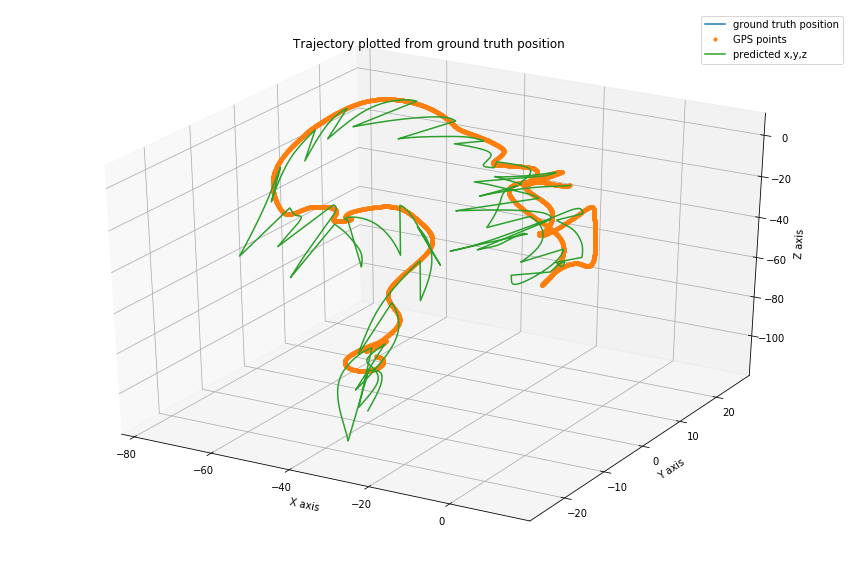

In [41]:
P0 = []
P1 = []
P2 = []
P3 = []
P4 = []
P5 = []
P6 = []
P7 = []
P8 = []

GPSpointsX = []
GPSpointsY = []
GPSpointsZ = []

TestYaw = []
TestPitch = []
TestRoll = [] 

X = []
Y = []
Z = []
p_x = 0
p_y = 0
p_z = 0
X.append(p_x)
Y.append(p_y)
Z.append(p_z)

VX = []
VY = []
VZ = []
# TODO: initial vx0 for testing
v_x = vx[0]
v_y = vy[0]
v_z = vz[0]
VX.append(v_x)
VY.append(v_y)
VZ.append(v_z)

AXS = []
AYS = []
AZS = []
AZGS = []

ya = yaw0
pi = pitch0
ro = roll0

Test = []
Test2 = []

#state matrix 
x = np.mat([0, 0, 0, vx[0], vy[0], vz[0], yaw0, pitch0, roll0]).T

for i in range(length): #len(ax)):
#     print(i)
    
######### Prediction STEP starts ####################################################
    x[0] = x[0] + x[3]*dt
    x[1] = x[1] + x[4]*dt
    x[2] = x[2] + x[5]*dt
    
    # x[6]- yaw, x[7] - pitch, x[8]- roll 
    sa = sin(x[6]) # sin (yaw + yawrate)
    ca = cos(x[6]) # cos (yaw + yawrate)
    sb = sin(x[8]) # sin (roll + rollrate)
    cb = cos(x[8]) # cos (roll + rollrate
    sh = sin(x[7]) # sin (pitch + pitchrate)
    ch = cos(x[7]) # cos (pitch + pitchrate)
    
    m00 = ch*ca
    m01 = -ch*sa*cb + sh*sb
    m02 = ch*sa*sb + sh*cb
    m10 = sa
    m11 = ca*cb
    m12 = -ca*sb
    m20 = -sh*ca
    m21 = sh*sa*cb + ch*sb
    m22 = -sh*sa*sb + ch*cb
    
    Axs = (m00*ax[i] + m01*ay[i] + m02*az[i])
    Ays = (m10*ax[i] + m11*ay[i] + m12*az[i])
    Azgs = (m20*ax[i] + m21*ay[i] + m22*az[i])
    Azs = (m20*ax[i] + m21*ay[i] + m22*az[i] + 9.8)
    
    x[3] = x[3] + Axs*dt
    x[4] = x[4] + Ays*dt
    x[5] = x[5] + Azs*dt

        # Yaw, pitch, roll updated from gx, gy, gz only 
    x[6] = x[6] + gz[i]*dt
    x[7] = x[7] + gy[i]*dt
    x[8] = x[8] + gx[i]*dt 


    X.append(float(x[0]))
    Y.append(float(x[1]))
    Z.append(float(x[2]))
    
    a36 = dt*(-dt*ax[i]*sb*ch - dt*ay[i]*ch*cb*ca + dt*az[i]*sa*ch*cb)
    a46 = dt*(dt*ax[i]*cb - dt*ay[i]*ca + dt*az[i]*sb*sa)
    a56 = dt*(dt*ax[i]*sh*sb + dt*ay[i]*sh*cb*ca - dt*az[i]*sh*sa*cb)
    
    a37 = dt*(-dt*ax[i]*sh*cb + ay[i]*(dt*sh*sb*ca + dt*sa*ch) + az[i]*(-dt*sh*sb*sa + dt*ch*ca))
    a57 = dt*(-dt*ax[i]*ch*cb + ay[i]*(-dt*sh*sa + dt*sb*ch*ca) + az[i]*(-dt*sh*ca -dt*sb*sa*ch))
    
    a38 = dt*(ax[i]*(dt*sh*ca+dt*sb*sa*ch) + az[i]*(-dt*sh*sa + dt*sb*ch*ca))
    a48 = dt*(-dt*ay[i]*sa*cb - dt*az[i]*cb*ca)
    a58 = dt*(ay[i]*(-dt*sh*sb*sa + dt*ch*ca) + az[i]*(-dt*sh*sb*ca - dt*sa*ch))
    
    JA = np.matrix([[1,0,0,dt,0,0,0,0,0],
                    [0,1,0,0,dt,0,0,0,0],
                    [0,0,1,0,0,dt,0,0,0],
                    [0,0,0,1,0,0,a36, a37, a38],
                    [0,0,0,0,1,0,a46, 0,   a48],
                    [0,0,0,0,0,1,a56, a57, a58],
                    [0,0,0,0,0,0,dt,0,0],
                    [0,0,0,0,0,0,0,0,dt],
                    [0,0,0,0,0,0,0,dt,0]])
    
    g30 = dt*ch*cb
    g40 = dt*sb
    g50 = -dt*sh*cb
    
    g31 = dt*(sh*sa - sb*ch*ca)
    g41 = dt*cb*ca
    g51 = dt*(sh*sb*ca + sa*ch)
    
    g32 = dt*(sh*ca + sb*sa*ch)
    g42 = -dt*sa*cb
    g52 = dt*(-sh*sb*sa + ch*ca)
    
    g33 = dt*(-dt*ax[i]*sb*ch -dt*ay[i]*ch*cb*ca + dt*az[i]*sa*ch*cb)
    g43 = dt*(dt*ax[i]*cb - dt*ay[i]*sb*ca + dt*az[i]*sb*sa)
    g53 = dt*(dt*ax[i]*sh*sb + dt*ay[i]*sh*cb*ca - dt*az[i]*sh*sa*cb)
    
    g34 = dt*(-dt*ax[i]*sh*cb + ay[i]*(dt*sh*sb*ca+dt*sa*ch)+az[i]*(-dt*sh*sb*sa+dt*ch*ca))
    g54 = dt*(-dt*ax[i]*ch*cb + ay[i]*(-dt*sh*sa + dt*sb*ch*ca) + az[i]*(-dt*sh*ca-dt*sb*sa*ch))
    
    g35 = dt*(ay[i]*(dt*sh*ca*dt*sb*sa*ch)+az[i]*(-dt*sh*sa+dt*sb*ch*ca))
    g45 = dt*(-dt*ay[i]*sa*cb -dt*az[i]*cb*ca)
    g55 = dt*(ay[i]*(-dt*sh*sb*sa + dt*ch*ca) + az[i]*(-dt*sh*sb*ca - dt*sa*ch))
    
    JG = np.matrix([[0,0,0,0,0,0],
                    [0,0,0,0,0,0],
                    [0,0,0,0,0,0],
                    [g30,g31,g32,g33,g34,g35],
                    [g40,g41,g42,g43,0,  g45],
                    [g50,g51,g52,g53,g54,g55],
                    [0,0,0,dt,0,0],
                    [0,0,0,0,0,dt],
                    [0,0,0,0,dt,0]])
    
    P = JA*P*JA.T + JG*Q*JG.T
    
    hx = np.matrix([[float(x[0])],
                    [float(x[1])],
                    [float(x[2])],                    
                    [float(x[3])],
                    [float(x[4])],
                    [float(x[5])],
                    [float(x[6])],
                    [float(x[7])],
                    [float(x[8])]])
    
    if GPSFix[i]:
        print(i)
        #print("GPS")
        # Calculate the Jacobian of the Measurement Function
        # see "Measurement Matrix H"
        JH = np.eye(numstates)

        S = JH*P*JH.T + R 

    
        K = (P*JH.T) * np.linalg.inv(np.mat(S,dtype='float'))
        
#         print(K.shape)
#         y = np.mat([[mx[i]-x[0]],[my[i]-x[1]],[mz[i]-x[2]],[0],[0],[0],[YAW[i]-x[6]],[PITCH[i]-x[7]],[ROLL[i]-x[8]]])
#         print(K*y)
#         # Update the estimate via
        z = measurements[:,i].reshape(JH.shape[0],1)
#         print(z)
#         print(z[0][0])
        GPSpointsX.append(float(z[0]))
        GPSpointsY.append(float(z[1]))
        GPSpointsZ.append(float(z[2]))

        y = z - (hx)
        

        x = x + (K*y)


        #print((I - (K*JH)))
        #     # Update the error covariance
        P = (I - (K*JH))*P
        
        
    
######### Prediction STEP ends ####################################################

    P0.append(float(P[0,0]))
    P1.append(float(P[1,1]))
    P2.append(float(P[2,2]))
    P3.append(float(P[3,3]))
    P4.append(float(P[4,4]))
    P5.append(float(P[5,5]))
    P6.append(float(P[6,6]))
    P7.append(float(P[7,7]))
    P8.append(float(P[8,8]))



# plt.plot(X)
# plt.plot(mx)
# plt.show()
# plt.plot(Y)
# plt.plot(my)
# plt.show()
# plt.plot(Z)
# plt.plot(mz)
# plt.show()

# # calculateVfromA(Ax, vx[0])
# plt.plot(VX)
# plt.plot(vx)
# plt.show()
# plt.plot(VY)
# plt.plot(vy)
# plt.show()
# plt.plot(VZ)
# plt.plot(vz)
# plt.show()

# plt.plot(AXS)
# plt.plot(Ax)
# plt.show()
# plt.plot(AYS)
# plt.plot(Ay)
# plt.show()
# plt.plot(AZS)
# plt.plot(Az)
# plt.show()

# # Acceleration calculated from Velocity
# fig, (axplot1, axplot2, axplot3) = plt.subplots(3, sharex=True, sharey=True)
# axplot1.plot(AXS, label='calculated Ax from ax')
# axplot1.plot(Ax, label='ground truth of Ax')
# axplot1.set_title('Acceleration in world frame calculated from acceleration in local frame')
# axplot1.legend()
# axplot2.plot(AYS, label='calculated Ay from ay')
# axplot2.plot(Ay, label='ground truth of Ay')
# axplot2.legend()
# axplot3.plot(AZS, label='calculated Az from az')
# axplot3.plot(Az, label='ground truth of Az + gravity')
# axplot3.legend()
# fig.subplots_adjust(hspace=0)




fig = plt.figure(figsize=(15,10))
axplot = fig.gca(projection='3d')
axplot.set_title("Trajectory plotted from ground truth position")
axplot.plot(rmx, rmy, rmz, label='ground truth position')
axplot.plot(rmx, rmy, rmz,'.', label='GPS points')
axplot.plot(X,Y,Z, label='predicted x,y,z')
axplot.legend()
axplot.set_xlabel('X axis')
axplot.set_ylabel('Y axis')
axplot.set_zlabel('Z axis')
plt.show()

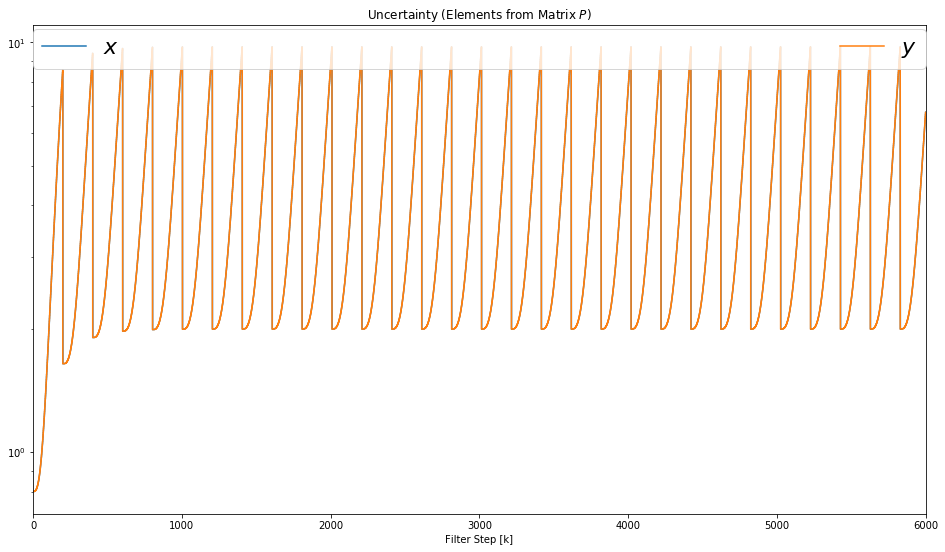

In [42]:
m = length
fig = plt.figure(figsize=(16,9))
plt.semilogy(range(m),P0, label='$x$')
plt.step(range(m),P1, label='$y$')
# plt.step(range(m),P2, label='$z$')
# plt.step(range(m),P3, label='$vx$')
# plt.step(range(m),P4, label='$vy$')
# plt.step(range(m),P5, label='$\psi$')
# plt.step(range(m),P6, label='$\Theta$')
# plt.step(range(m),P7, label='$\phi$')
# plt.step(range(m),P7, label='$\phi$')

plt.xlabel('Filter Step [k]')
plt.ylabel('')
plt.xlim(0,m)
plt.title('Uncertainty (Elements from Matrix $P$)')
#plt.legend(loc='best',prop={'size':22})
plt.legend(bbox_to_anchor=(0., 0.91, 1., .06), loc=3,
       ncol=9, mode="expand", borderaxespad=0.,prop={'size':22})
plt.savefig('Covariance-Matrix-Verlauf.eps', bbox_inches='tight')

In [43]:
lIX = X 
lIY = Y
lIZ = Z 

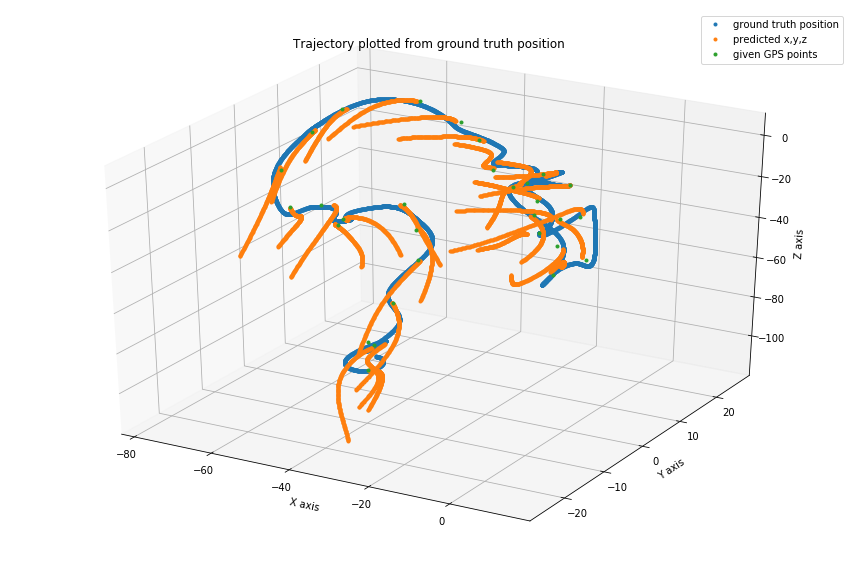

In [44]:
fig = plt.figure(figsize=(15,10))
axplot = fig.gca(projection='3d')
axplot.set_title("Trajectory plotted from ground truth position")
axplot.plot(rmx[0:length], rmy[0:length], rmz[0:length],'.', label='ground truth position')
# axplot.plot(mx[0:length], my[0:length], mz[0:length],'.', label='ground truth position')
# axplot.plot(lIX[0:length], lIY[0:length], lIZ[0:length], '.',label = 'prev')
axplot.plot(X[0:length],Y[0:length],Z[0:length], '.',label='predicted x,y,z')
#axplot.plot(noKX[0:length],noKY[0:length],noKZ[0:length], '.',label='no kalman filter')
axplot.plot(GPSpointsX,GPSpointsY,GPSpointsZ, '.',label='given GPS points')

axplot.legend()
axplot.set_xlabel('X axis')
axplot.set_ylabel('Y axis')
axplot.set_zlabel('Z axis')
plt.show()

In [45]:
# sQX = X 
# sQY = Y
# sQZ = Z
# lQX = X 
# lQY = Y
# lQZ = Z
lGX = X 
lGY  = Y
lGZ = Z 

# Symbols

In [46]:
xs, ys, zs, dts, vxs, vys, vzs, yawss, pitchss, rollss, axs, ays, azs, yawrates, pitchrates, rollrates = \
 symbols('x y z T v_x v_y v_z \phi \Theta \psi a_x a_y a_z, \dot\phi \dot\Theta \dot\psi')
    

yas = yawss + yawrates*dts
ros = rollss + rollrates*dts
pis = pitchss + pitchrates*dts

sas = sin(yas) #yaw
cas = cos(yas) #yaw
sbs = sin(ros) #roll
cbs = cos(ros) #roll
shs = sin(pis) #pitch
chs = cos(pis) #pitch

m00s = chs*cas
m01s = -chs*sas*cbs + shs*sbs
m02s = chs*sas*sbs + shs*cbs
m10s = sas
m11s = cas*cbs
m12s = -cas*sbs
m20s = -shs*cas
m21s = shs*sas*cbs + chs*sbs
m22s = -shs*sas*sbs + chs*cbs

Axss = m00s*axs + m01s*ays + m02s*azs
Ayss = m10s*axs + m11s*ays + m12s*azs
Azgss = m20s*axs + m21s*ays + m22s*azs 
Azss = m20s*axs + m21s*ays + m22s*azs +9.8




As = Matrix([[xs + vxs*dts],[ys+vys*dts],[zs+vzs*dts],[vxs + Axss*dts],[vys+Ayss*dts],[vzs+Azss*dts],[yas],[ros],[pis]])

state = Matrix([[xs],[ys],[zs],[vxs],[vys],[vzs],[yawrates],[pitchrates],[rollrates]])

# vxs, vys, vzs, psis, dpsis, dts, xs, ys, zs, axs, ays, azs, phis, dphis, thetas, dthetas, Lats, Lons = \
#  symbols('v_x, v_y, v_z \psi \dot\psi T x y z a_x, a_y, a_z, \phi \dot\phi \Theta \dot\Theta Lat Lon')

# As = Matrix([[xs+(vxs/dpsis)*(sin(psis+dpsis*dts)-sin(psis))],
#              [ys+((vxs/dpsis)*(-cos(psis+dpsis*dts)+cos(psis))) + ((vys/dphis)*(sin(phis+dphis*dts)-sin(phis)))],
#              [zs+(vys/dphis)*(-cos(phis+dphis*dts)+cos(phis))],
#              [vxs + axs*dts],
#              [vys + ays*dts],
#              [psis+dpsis*dts],
#              [thetas+dthetas*dts],
#              [phis+dphis*dts]])
# state = Matrix([xs,ys,zs,vxs,vys,psis,thetas,phis])

In [47]:
As

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢    T⋅(aₓ⋅cos(T⋅\dot\Theta + \Theta)⋅cos(T⋅\dot\phi + \phi) + a_y⋅(sin(T⋅\dot
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢T⋅(-aₓ⋅sin(T⋅\dot\Theta + \Theta)⋅cos(T⋅\dot\phi + \phi) + a_y⋅(sin(T⋅\dot\Th
⎢                                                                             
⎢                                                   

In [48]:
state

⎡    x     ⎤
⎢          ⎥
⎢    y     ⎥
⎢          ⎥
⎢    z     ⎥
⎢          ⎥
⎢    vₓ    ⎥
⎢          ⎥
⎢   v_y    ⎥
⎢          ⎥
⎢   v_z    ⎥
⎢          ⎥
⎢ \dot\phi ⎥
⎢          ⎥
⎢\dot\Theta⎥
⎢          ⎥
⎣ \dot\psi ⎦

In [49]:
As.jacobian(state)

⎡1  0  0  T  0  0                                                             
⎢                                                                             
⎢0  1  0  0  T  0                                                             
⎢                                                                             
⎢0  0  1  0  0  T                                                             
⎢                                                                             
⎢0  0  0  1  0  0  T⋅(-T⋅aₓ⋅sin(T⋅\dot\phi + \phi)⋅cos(T⋅\dot\Theta + \Theta) 
⎢                                                                             
⎢0  0  0  0  1  0                                           T⋅(T⋅aₓ⋅cos(T⋅\dot
⎢                                                                             
⎢0  0  0  0  0  1  T⋅(T⋅aₓ⋅sin(T⋅\dot\Theta + \Theta)⋅sin(T⋅\dot\phi + \phi) +
⎢                                                                             
⎢0  0  0  0  0  0                                   

In [50]:
control = Matrix([axs, ays, azs, yawrates, pitchrates, rollrates ])
control

⎡    aₓ    ⎤
⎢          ⎥
⎢   a_y    ⎥
⎢          ⎥
⎢   a_z    ⎥
⎢          ⎥
⎢ \dot\phi ⎥
⎢          ⎥
⎢\dot\Theta⎥
⎢          ⎥
⎣ \dot\psi ⎦

In [51]:
JGs = As.jacobian(control)
JGs

⎡                         0                                                   
⎢                                                                             
⎢                         0                                                   
⎢                                                                             
⎢                         0                                                   
⎢                                                                             
⎢T⋅cos(T⋅\dot\Theta + \Theta)⋅cos(T⋅\dot\phi + \phi)   T⋅(sin(T⋅\dot\Theta + \
⎢                                                                             
⎢              T⋅sin(T⋅\dot\phi + \phi)                                       
⎢                                                                             
⎢-T⋅sin(T⋅\dot\Theta + \Theta)⋅cos(T⋅\dot\phi + \phi)  T⋅(sin(T⋅\dot\Theta + \
⎢                                                                             
⎢                         0                         